In [3]:
from lrgsglib.core import *

In [41]:
vals= {}

In [46]:
for pflip in [0.001, 0.01, 0.1, 0.3]:
    l = Lattice2D(64, pflip=pflip, init_nw_dict=True)
    # l.flip_sel_edges(l.nwDict['single']['G'])
    l.flip_random_fract_edges()
    l.compute_laplacian_spectrum_weigV()
    l.make_rescaled_signed_laplacian()
    # --- parameters as before ---
    n      = l.N           # e.g. 1024
    T      = 1000000              # total steps
    dt = 1e-3
    sigma  = 1e-8                 # noise std
    N      = 100                # number of random initial conditions

    # 1) precompute transition and noise covariance
    # build & diagonalize M
    M = np.eye(n) - dt * l.resLp
    w, Q = np.linalg.eigh(M)     # w: eigenvalues, Q: orthonormal

    # compute series sum s_i = ∑_{k=0}^{T-1} w_i^{2k}
    # if |w_i|!=1: (1 - w_i**(2T))/(1 - w_i**2), else: T
    den = 1 - w**2
    s = np.where(np.abs(den)>1e-12,
                (1 - w**(2*T)) / den,
                T)

    # sample all final states in one shot
    # 1) deterministic drift
    M_T = Q @ np.diag(w**T) @ Q.T
    X0  = np.random.uniform(-1, 1, size=(n, N))
    det = M_T @ X0

    # 2) noise: Q @ diag(sqrt(σ² s_i)) @ Z
    Z     = np.random.randn(n, N)
    noise = Q @ (np.sqrt(sigma**2 * s)[:,None] * Z)

    X_T = det + noise
    X_T = np.sign(X_T)
    # overlaps
    norms    = np.linalg.norm(X_T, axis=0)
    Gram     = X_T.T @ X_T
    overlaps = Gram / np.outer(norms, norms)
    i,j      = np.triu_indices(N, k=1)
    vals[pflip]     = overlaps[i,j]

/tmp/ipykernel_97380/302121816.py:23: RuntimeWarning: invalid value encountered in divide
  (1 - w**(2*T)) / den,


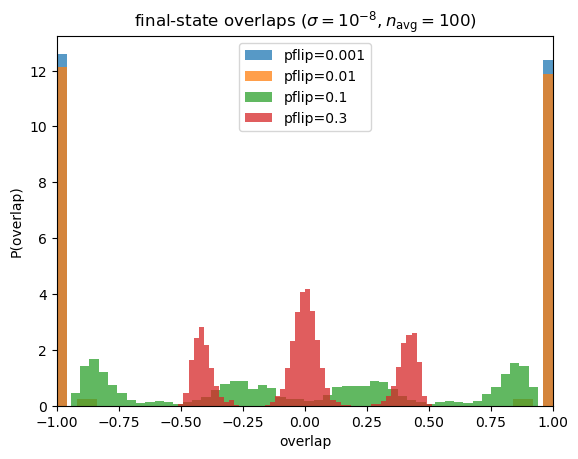

In [50]:
for pflip in [0.001, 0.01, 0.1, 0.3]:
    plt.hist(np.array(vals[pflip]).flatten(), label='pflip={}'.format(pflip), bins=50, density=True, alpha=0.75)

plt.xlabel('overlap')
plt.ylabel('P(overlap)')
plt.title(r'final‐state overlaps ($\sigma=10^{-8}, n_{\rm avg} = 100$)')
plt.xlim(-1, 1)
plt.legend()
plt.show()

In [ ]:
xarr = []

In [ ]:
x0 = np.sign(np.random.uniform(-1, 1, l.N))
# x0 = l.eigV[2]
plt.imshow(x0.reshape(*l.syshape), cmap='hot')
plt.colorbar()

In [ ]:
dt = 1e-3
tsteps = 100000
sigma = 0               # standard deviation of the Gaussian noise
M = np.eye(x0.shape[0]) - dt * l.resLp

# initialize
x = x0.ravel().copy()

# time evolution with additive Gaussian noise
for _ in range(tsteps):
    η = np.random.normal(loc=0.0, scale=sigma, size=x.shape)
    # η = 0
    x = np.array(M @ x + η).flatten()
xarr.append(x)

In [ ]:
fig, ax = plt.subplots(ncols=len(xarr), figsize=(10, 5))
for i in range(len(xarr)):
    ax[i].imshow(np.sign(xarr[i]).reshape(*l.syshape), cmap='hot')